# FEM: 1D Beispiel mit Python
Dr. Zoufiné Lauer-Baré





## Lineare Elastiziät: Gleichungen
Im Gebiet (den Bauteilen) bei isotropem Material
\begin{align}
-\nabla \cdot \mathbf{\Sigma}&=\mathbf{f} &\text{ Impulserhaltung}\\
\mathbf{\Sigma} & =2\mu \mathbf{E}+\lambda \text{tr}(\mathbf{E})\mathbf{I} &\text{ Hook-Gesetz: Spannung-Dehnung}\\
\mathbf{E} & = \frac{1}{2}\left(\nabla \mathbf{u}+(\nabla \mathbf{u})^T\right)&\text{ Dehnung-Verschiebung}
\end{align}
An jeder Stelle des Randes müssen Randbedingungen definiert sein. Hierbei ist $\mathbf{f}$ eine Volumenkraft, $$\mathbf{u}(x_1,x_2,x_3)= \begin{pmatrix}u_1(x_1,x_2,x_3)\\u_2(x_1,x_2,x_3)\\u_3(x_1,x_2,x_3) \end{pmatrix}$$ die Verschiebung. 



Hierbei ist die Dehnung $\mathbf{E}=\left(e_{ij}\right)_{ij=1,2,3}$ im Detail gegeben durch ($i,j=1,2,3$) $$e_{ij}=\frac{1}{2}\left(\frac{\partial u_i}{\partial x_j}+\frac{\partial u_j}{\partial x_i}\right).$$

Die Komponenten der oberen Spannungsmatrix $\mathbf{\Sigma}=\left(\sigma_{ij}\right)_{ij=1,2,3}$ sind ($i\neq j$) $$\sigma_{ij}=2\mu e_{ij}.$$

Für $i=j$ $$\sigma_{ii}=2\mu e_{ii}+\lambda\nabla\cdot\mathbf{u}$$

Manchmal wird auch $\mathbf{u}=(u,v,w)^T$ geschrieben.
$\lambda$ und $\mu$ (Schubmodul) sind Materialparameter die Lamé-Parameter genannt werden.

Statt $\lambda$ und $\mu$ werden oft auch der Elastizitätsmodul $E$ und die Querkontraktionsszahl $\nu$ angegeben.

### Materialkonstanten

\begin{align}
&E=\frac{\mu(3\lambda+2\mu)}{\lambda+\mu} &\nu=\frac{\lambda}{2(\lambda+\mu)}\\
&\lambda=\frac{E\nu}{(1+\nu)(1-2\nu)} &\mu=\frac{E}{2(1+\nu)}
\end{align}

# Exemplarischer FEM Prozess in 1D: Mit Vorgegebener Verschiebung




## Physikalische Modellierung


Zum Beispiel, Ermittlung der Verschiebung, Spannung und Dehnung eines Zylinders. Das einfachste Modell hierzu ist das "Zugstab-Modell". Hier können die gesuchten Größen analytisch berechnet werden. Deswegen kann anhand dieses Beispiels die Finite Elemenete Methode gut illustriert werden.

\begin{align}
-\frac{\partial }{\partial x} \cdot E \frac{\partial u}{\partial x}&= f &x\in (0,2)\label{inner}\\
u(0) & =u_{Dirichlet0} \\
u(2) & =u_{Dirichlet2} 
\end{align}


## Preprocessing: Diskretisierung/Vernetzung



Aufteilung des Berechnungsgebietes in einzelne "Elemente", in diesem Fall Linien. In diesem Fall in 5 Punkte (Knoten): $$0, \frac{1}{2}, 1, \frac{3}{2}, 2 $$
Die Elemente haben in diesem Fall die gleiche Länge: $\frac{1}{3}$. Das muss nicht so sein.

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib import ticker
import numpy as np
from scipy import integrate
from fem.funktionen import *
import seaborn as sns
mpl.rcParams["figure.figsize"] = (20,7)
mpl.rcParams['lines.linewidth'] = 4
mpl.rcParams['lines.markersize'] = 11

#sns.set()
farben = sns.color_palette()
plt.style.use('seaborn-darkgrid')

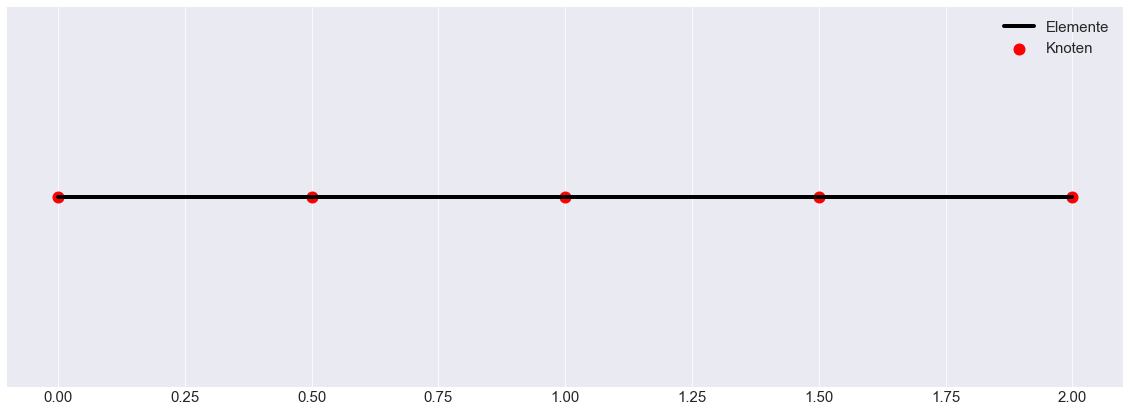

In [3]:
x=np.linspace(0,2,1000)
ax=plt.axes()
ax.tick_params(labelsize=15)

ax.plot(np.array([0,1/2.,1,3/2.,2]), np.array([0,0,0,0,0]), label='Elemente', color='black')
ax.scatter(np.array([0,1/2.,1,3/2.,2]), np.array([0,0,0,0,0]), label='Knoten',color='red')
ax.tick_params(labelsize=15)
#ax.set_axis_off()
ax.axes.get_yaxis().set_visible(False)
plt.legend(loc='best',fontsize=15)

## Solving

### Berechnung der Steifigkeitsmatrix

Ansatz (Nach Ritz): $$u_{fem}=u_0 N_0(x)+u_{\frac{1}{2}} N_{\frac{1}{2}}(x)+u_1 N_1(x)+u_{\frac{3}{2}} N_{\frac{3}{2}}(x)+u_2 N_2(x)$$ 

Die Formfunktionen $N_i$ sind so definiert, dass sie an ihrem eigenen Knoten 1 sind und an anderen Knoten 0. Die Koeffizienten der Knoten $u_i$ sind konstant und unbekannt. Bei FEM geht es im "solving" darum, diese Koeffizienten $\boldsymbol{u}=(u_0, u_{\frac{1}{2}},u_1,u_{\frac{3}{2}},u_2)^T$ zu berechnen. Sind die Koeffizienten bestimmt, ist die Approximation der Verschiebung $u_{fem}$ bestimmt!


In einem nächsten Schritt wird mit etwas Mathematik (Analysis und lineare Algebra) eine "Steifigkeitsmatrix" $\boldsymbol{K}$ hergeleitet und eine entsprechende rechte Seite $\boldsymbol{b}$. Am Ende des Tages steht dann ein lineares Gleichungssystem, dass numerisch gelöst wird: $$K \boldsymbol{u}=\boldsymbol{b}$$

Um konkret die Steifigkeitsmatrix zu berechnen, müssen konkrete Formfunktionen $N_i$ gewählt werden, z.B. "Hütchenfunktionen" (Lagrange-Polynome erster Ordnung). Im Fall des aktuellen Beispiels:

\begin{align}
N_0 = 
\begin{cases}
1-2x & x\in [0,\frac{1}{2}) \\
0 & \, \text{sonst}
\end{cases}
\end{align}

\begin{align}
N_2 = 
\begin{cases}
2(x-\frac{3}{2}) & x\in [\frac{3}{2},2) \\
0 & \, \text{sonst}
\end{cases}
\end{align}

Für $i=1,\frac{1}{2},\frac{3}{2}$

\begin{align}
N_i= 
\begin{cases}
2(x-(i-\frac{1}{2})) & x\in [i-\frac{1}{2},i) \\
1-2(x-i)& x\in [i,i+\frac{1}{2}) \\
0 & \, \text{sonst}
\end{cases}
\end{align}

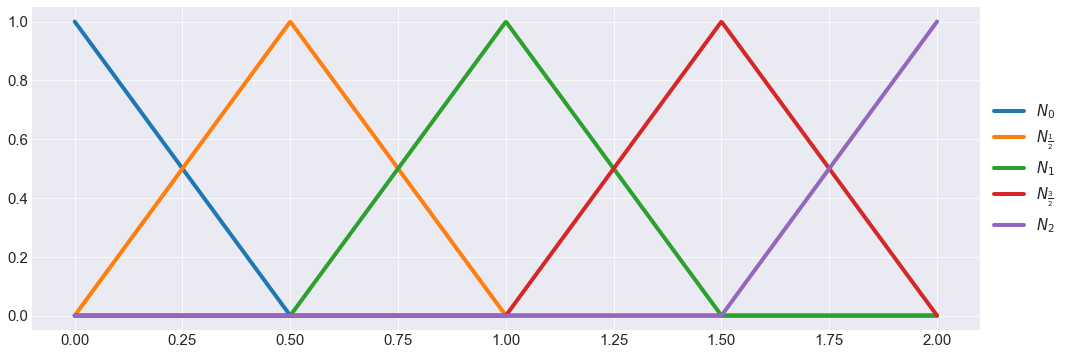

In [4]:

ax=plt.axes()
ax.plot(x,Nh(x,0), label=r'$N_{0}$')
ax.plot(x,Nh(x,1/2.), label=r'$N_{\frac{1}{2}}$')
ax.plot(x,Nh(x,1), label=r'$N_{1}$')
ax.plot(x,Nh(x,3/2.), label=r'$N_{\frac{3}{2}}$')
ax.plot(x,Nh(x,2), label=r'$N_{2}$')
ax.tick_params(labelsize=15)
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.85, box.height* 0.85])
plt.legend(loc='center left', prop={'size':15}, bbox_to_anchor=(1, 0.5))
plt.show()

Um die Steifigkeitsmatrix zu bekommen wird die Gleichung $-\frac{\partial u}{\partial x} \cdot E \frac{\partial u}{\partial x}= f$ mit einer beliebigen Funktion $v$ multipliziert und es wird partiell integriert:
$$-E\int_{0}^{2}\frac{\partial }{\partial x}\frac{\partial u}{\partial x}vdx=\int_{0}^{2}fvdx$$

$$E\int_{0}^{2}\frac{\partial u}{\partial x}\frac{\partial v}{\partial x}dx-\frac{\partial u}{\partial x}v\rvert_{0}^{2}=\int_{0}^{2}fvdx$$

Dann werden die Verschiebung $u$ und die Testfunktion $v$ mit Linearkombinationen der Formfunktionen approximmiert und in die Gleichung eingesetzt.
\begin{align}
u_{fem}&=u_0 N_0(x)+u_{\frac{1}{2}} N_{\frac{1}{2}}(x)+u_1 N_1(x)+u_{\frac{3}{2}} N_{\frac{3}{2}}(x)+u_2 N_2(x)\\
v&=v_0 N_0(x)+v_{\frac{1}{2}} N_{\frac{1}{2}}(x)+v_1 N_1(x)+v_{\frac{3}{2}} N_{\frac{3}{2}}(x)+v_2 N_2(x)
\end{align}


Um nach dem Einsetzen mit den Rechenregeln für Matrizen und ihrer transponierten die Steifigkeitsmatrix zu erhalten, werden $u_{fem}$ und $v$ kompakter als Matrixprodukt geschrieben:
    
\begin{align}
u_{fem}&=\boldsymbol{N}^T\boldsymbol{u}\\
v&=\boldsymbol{N}^T\boldsymbol{v}
\end{align}

wobei 

\begin{align}
\boldsymbol{u}=(u_0, u_{\frac{1}{2}},u_1,u_{\frac{3}{2}},u_2)^T\\
\boldsymbol{v}=(v_0, v_{\frac{1}{2}},v_1,v_{\frac{3}{2}},v_2)^T\\
\boldsymbol{N}=(N_0, N_{\frac{1}{2}},N_1,N_{\frac{3}{2}},N_2)^T
\end{align}


Im Folgenden ist es wichtig zu wissen, dass für zwei Matrizen $\boldsymbol{A},\boldsymbol{B}\in \mathbb{R}^{n\times 1}$ gilt:

\begin{align}
\left(\boldsymbol{A}\boldsymbol{B}\right)^T=\boldsymbol{B}^T\boldsymbol{A}^T\\
\end{align}

In dem aktuellen Beispiel ist dazu noch wichtig, dass $$\left(\boldsymbol{N}^T\boldsymbol{u}\right)^T=\boldsymbol{N}^T\boldsymbol{u}$$

Gerne testen!

Mit etwas linearer Algebra erhählt man dann

\begin{align}
\boldsymbol{v}^T\left(E\int_{0}^{2}\frac{\partial \boldsymbol{N}}{\partial x}\frac{\partial \boldsymbol{N}^T}{\partial x}dx-\frac{\partial \boldsymbol{N}}{\partial x}\boldsymbol{N}^T\rvert_{0}^{2}\right)\boldsymbol{u}=\boldsymbol{v}^Tf\int_{0}^{2}\boldsymbol{N}dx
\end{align}

Da diese Gleichung für alle Testfunktionen gelten soll, kann $\boldsymbol{v}^T$ weggelassen werden und man erhält das gesuchte Gleichungssystem

\begin{align}
\left(E\int_{0}^{2}\frac{\partial \boldsymbol{N}}{\partial x}\frac{\partial \boldsymbol{N}^T}{\partial x}dx-\frac{\partial \boldsymbol{N}}{\partial x}\boldsymbol{N}^T\rvert_{0}^{2}\right)\boldsymbol{u}=f\int_{0}^{2}\boldsymbol{N}dx
\end{align}

oder 

$$\boldsymbol{K} \boldsymbol{u}=\boldsymbol{b}$$

 mit 
 
\begin{align}
\boldsymbol{K}&=E\int_{0}^{2}\frac{\partial \boldsymbol{N}}{\partial x}\frac{\partial \boldsymbol{N}^T}{\partial x}dx-\frac{\partial \boldsymbol{N}}{\partial x}\boldsymbol{N}^T\rvert_{0}^{2}\\
\boldsymbol{b}&=f\int_{0}^{2}\boldsymbol{N}dx
\end{align}

Um die Steifigkeitsmatrix konkret zu berechnen um das Gleichungssystem numerisch zu lösen müssen die oberen Integrale berechnet werden und die Randbedingungen berücksichtigt werden.

Ableiten, ausmultiplizieren und integrieren ergibt:
    
\begin{align}
E\int_{0}^{2}\frac{\partial \boldsymbol{N}}{\partial x}\frac{\partial \boldsymbol{N}^T}{\partial x}dx&=
\begin{pmatrix}
2 & -2 & 0 & 0 & 0 \\
-2 & 4 & -2 & 0 & 0 \\
0 & -2 & 4 & -2 & 0   \\
0 & 0 & -2 & 4 & -2 \\
0 & 0 & 0 & -2 & 2
\end{pmatrix}\\
\frac{\partial \boldsymbol{N}}{\partial x}\boldsymbol{N}^T\rvert_{0}^{2}&=
\begin{pmatrix}
1 & 0 & 0 & 0 & 0 \\
0 & 0 & 0 & 0 & 0 \\
0 & 0 & 0 & 0 & 0 \\
0 & 0 & 0 & 0 & 0 \\
0 & 0 & 0 & 0 & 1
\end{pmatrix}\\
f\int_{0}^{2}\boldsymbol{N}dx&=f\begin{pmatrix}
\frac{1}{4}  \\
\frac{1}{2}  \\
\frac{1}{2} \\
\frac{1}{2} \\
\frac{1}{4}  
\end{pmatrix}
\end{align}    

Damit ergibt das Gleichungssystem $$K \boldsymbol{u}=\boldsymbol{b}$$

\begin{align}
E
\begin{pmatrix}
1 & -2 & 0 & 0 & 0 \\
-2 & 4 & -2 & 0 & 0 \\
0 & -2 & 4 & -2 & 0   \\
0 & 0 & -2 & 4 & -2 \\
0 & 0 & 0 & -2 & 1
\end{pmatrix}
\begin{pmatrix}
u_0  \\
u_{\frac{1}{2}}  \\
u_{\frac{1}{2}} \\
u_{\frac{1}{2}} \\
u_2  
\end{pmatrix}=
f\begin{pmatrix}
\frac{1}{4}  \\
\frac{1}{2}  \\
\frac{1}{2} \\
\frac{1}{2} \\
\frac{1}{4}  
\end{pmatrix}
\end{align}

oder, wenn die Elementlänge $\frac{1}{2}$ invertiert (d.h. $2$) ausgeklammert wird

\begin{align}
2E
\begin{pmatrix}
\frac{1}{2} & -1 & 0 & 0 & 0 \\
-1 & 2 & -1 & 0 & 0 \\
0 & -1 & 2 & -1 & 0   \\
0 & 0 & -1 & 2 & -1 \\
0 & 0 & 0 & -1 & \frac{1}{2}
\end{pmatrix}
\begin{pmatrix}
u_0  \\
u_{\frac{1}{2}}  \\
u_{\frac{1}{2}} \\
u_{\frac{1}{2}} \\
u_2  
\end{pmatrix}=
f\begin{pmatrix}
\frac{1}{4}  \\
\frac{1}{2}  \\
\frac{1}{2} \\
\frac{1}{2} \\
\frac{1}{4}  
\end{pmatrix}
\end{align}


Da in dem aktuellen Beispiel $u_0=u_{Dirichlet0}$, $u_2=u_{Dirichlet2}$ vorgegeben sind, muss das im oberen Gleichungssystem noch berücksichtigt werden. Dafür gibt es mehrere Möglichkeiten (siehe z.B. [Fish, Belytschko, 2007]). Ein weit verbreitetes Verfhren (robust) wird verständlich von [Rieg, Hackenschmidt,2009] vorgestellt. Dabei werden die Zeilen und Spalten von $u_0$, $u_2$ in jeweilige Einheitsvektoren verwandelt und von der rechten Seite die mit $u_{Dirichlet0}$ und $u_{Dirichlet2}$ skalierten Spalten der ursprünglichen Steifigkeitsmatrix (außer die Einträge die $u_0$ und $u_2$ treffen würden) abgezogen. Anschließend werden mit $u_{Dirichlet0}$ und $u_{Dirichlet2}$ skalierte Einheitsvektoren auf die rechte Seite addiert. 

\begin{align}
\begin{pmatrix}
1 & 0 & 0 & 0 & 0 \\
0 & 4E & -2E & 0 & 0 \\
0 & -2E & 4E & -2E & 0   \\
0 & 0 & -2E & 4E & 0 \\
0 & 0 & 0 & 0 & 1
\end{pmatrix}
\begin{pmatrix}
u_0  \\
u_{\frac{1}{2}}  \\
u_{\frac{1}{2}} \\
u_{\frac{1}{2}} \\
u_2  
\end{pmatrix}=
f\begin{pmatrix}
0 \\
\frac{1}{2}  \\
\frac{1}{2} \\
\frac{1}{2} \\
0  
\end{pmatrix}
-
\begin{pmatrix}
0  \\
-2E  \cdot u_{Dirichlet0}  \\
0 \\
-2E \cdot u_{Dirichlet2}  \\
0  
\end{pmatrix}
+
\begin{pmatrix}
u_{Dirichlet0}  \\
0  \\
0 \\
0 \\
u_{Dirichlet2}  
\end{pmatrix}
\end{align}

### Lösen des Gleichungssystems

Das lineare Gleichungssystem wird dann numerisch gelöst (siehe z.B. [Rieg, Hackenschmidt,2009]). Im folgenden werden konkrete Werte genommen und die mit FEM berechnete Funktion $u_{FEM}$ wird mit der analytischen Lösung $$u_{ana}=\left(\frac{u_{Dirichlet2} - u_{Dirichlet1} }{2}+\frac{f(2-x)}{2 E}\right)x+u_{Dirichlet1}$$ verglichen.

Als Beispiel sei der Stab aus Baustahl und $2 m$ lang, mit einem Querschnitt der einen $10 cm$ Radius hat, an einem Ende an der Decke befestigt und am unteren Ende auch fest. Der Stab wird durch Schwerkraft nach unten gezogen. 
Für das numerische Beispiel sei das E-Modul $E=2\cdot 10^{11} Pa$, $u_{Dirichlet1}=0 m$, $u_{Dirichlet2}=0 m$, $f=7850\cdot 9.86\frac{N}{m^3}$.

In [5]:
emod=200 #stahl
#emod=0.1 # gummi
#emod=0.01 # styropor, Dichte theoretisch auch anpassen
A=np.pi*(10/100.)**2
Laenge=2.

E=emod*10**9
u0=0
u2=0
gewicht=(7850)*(Laenge*A)
kraft=gewicht*9.8066

f=kraft/(Laenge*A)

K=2*E*np.array([[0,-1,0,0,0],
            [-1,2,-1,0,0],
            [0,-1,2,-1,0],
            [0,0,-1,2,-1],
            [0,0,0,-1,0]])


K0=2*E*np.array([[(2*E)**(-1),0,0,0,0],
            [0,2,-1,0,0],
            [0,-1,2,-1,0],
            [0,0,-1,2,0],
            [0,0,0,0,(2*E)**(-1)]])




rhsKorrektur=-K.T[0]*u0-K.T[4]*u2+u0*np.array([1,0,0,0,0])+u2*np.array([0,0,0,0,1])
F=f/(2.)*np.array([0,1,1,1,0])+rhsKorrektur

U=np.linalg.solve(K0,F)

#print(rhsKorrektur)

Ansatz (Nach Ritz): $$u_{fem}=u_0 N_0(x)+u_{\frac{1}{2}} N_{\frac{1}{2}}(x)+u_1 N_1(x)+u_{\frac{3}{2}} N_{\frac{3}{2}}(x)+u_2 N_2(x)$$ 

1.9245433215998785e-07


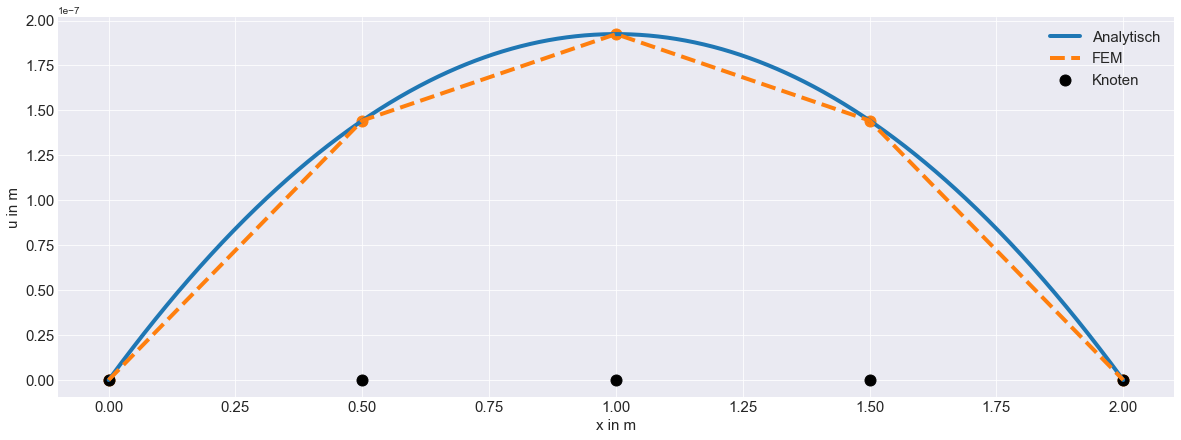

In [6]:
u=U[0]*Nh(x,0)+U[1]*Nh(x,1/2.)+U[2]*Nh(x,1)+U[3]*Nh(x,3/2.)+U[4]*Nh(x,2)



def uAna(y):

    wert=((u2-u0)/2.+(f*(2-y))/(2.*E))*y+u0     
        

    return wert

ax=plt.axes()
ax.tick_params(labelsize=15)
ax.plot(x,uAna(x), label='Analytisch', color=farben[0]),
ax.plot(x,u, label='FEM', linestyle='--', color=farben[1])
ax.scatter(np.array([0,1/2.,1,3/2.,2]), uAna(np.array([0,1/2.,1,3/2.,2])), label='', color=farben[1])
ax.scatter(np.array([0,1/2.,1,3/2.,2]), np.array([0,0,0,0,0]), label='Knoten', color='black')
ax.tick_params(labelsize=15)
box = ax.get_position()
ax.set_xlabel(xlabel='x in m',fontsize=15)
ax.set_ylabel(ylabel='u in m',fontsize=15)
plt.legend(loc='best',fontsize=15)
print(max(uAna(x)))

## Berechnung der Kenngrößen: Postprocessing

Nach dem Solving-Schritt ist eine FEM-Approximation $u_{FEM}$ der Verschiebung $u$ bekannt. Meistens ist die eigentliche Kenngröße jedoch nicht die Verschiebung, sondern eine Größe, die sich aus der Verschiebung berechnet. In der linearen Elastizität z.B. die Dehnung oder die Spannung.

\begin{align}
\sigma & =E \epsilon &\text{ Hook-Gesetz: Spannung-Dehnung}\\
\epsilon & = \frac{\partial u}{\partial x} &\text{ Dehnung-Verschiebung}
\end{align}

Meistens wird aus der Dehnung und Spannung noch eine Vergleichsdehnung bzw. Vergleichsspannung berechnet (z.B. von Mises Vergleichsdehnung bzw. Vergleichsspannung). In 1D ist das nur der Betrag:

\begin{align}
\sigma_V & =\sqrt{\sigma^2} &\text{ Vergleichsspannung}\\
\epsilon_V & = \frac{1}{1+\nu}\sqrt{\epsilon^2} &\text{ Vergleichsdehnung}
\end{align}

Wobei $\nu=0.3$ bei Stahl; siehe [Issler et. al, 2003].

Zusätzlich kann auch die Dehnungsenergie als Integrale Postprocessinggröße ausgewertet werden.

$$\Pi=\frac{1}{2}A\int_{0}^{2}\epsilon\sigma dx$$

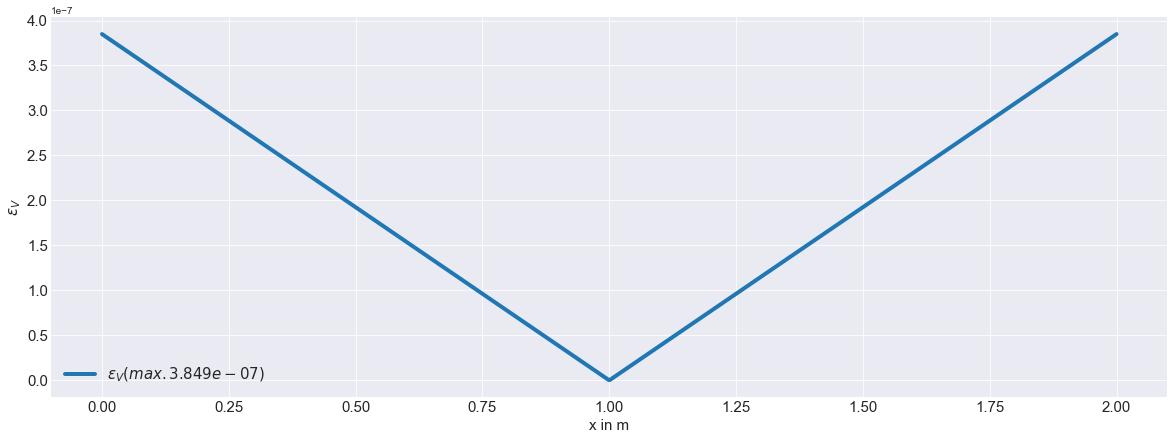

In [7]:
def dehnung(y):

    wert=(u2-u0)/2.+(f*(2-2*y))/(2.*E)     
        

    return wert

def spannung(y):
    wert=E*dehnung(y)
    return wert


ax=plt.axes()
ax.tick_params(labelsize=15)
ep=round(max(abs(dehnung(x))),10)
ax.plot(x,abs(dehnung(x)), label=r'$\epsilon_V (max. {0})$'.format(ep), color=farben[0])



ax.tick_params(labelsize=15)
ax.set_xlabel(xlabel='x in m',fontsize=15)
ax.set_ylabel(ylabel=r'$\epsilon_V$',fontsize=15)
plt.legend(loc='best',fontsize=15)

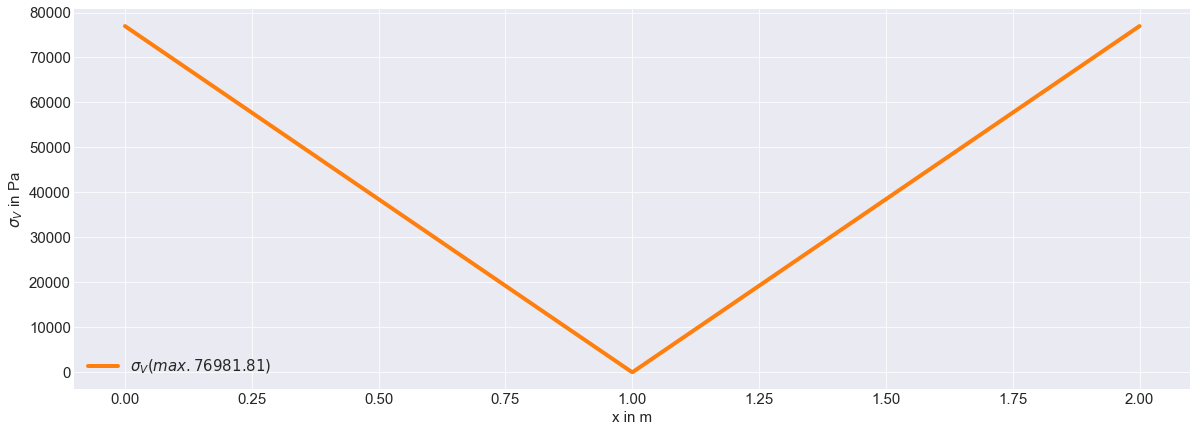

In [8]:
ax=plt.axes()
ax.plot(x,abs(spannung(x)), label=r'$\sigma_V (max. {0})$'.format(max(abs(spannung(x)))), color=farben[1])



ax.tick_params(labelsize=15)
ax.set_xlabel(xlabel='x in m',fontsize=15)
ax.set_ylabel(ylabel=r'$\sigma_V$ in Pa',fontsize=15)

plt.legend(loc='best',fontsize=15)

Ist das Ergebnis noch physikalisch, ist die Spannung noch im linearen Bereich? $$\sigma_V=7.74\cdot10^{-5}MPa<200 MPa$$

Dehnungsenergie in Joule (J) $$\Pi=\frac{1}{2}A\int_{0}^{2}\epsilon\sigma dx$$

In [18]:
0.5*A*integrate.simps(dehnung(x)*spannung(x), x)

0.00031029505836870585